In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import optuna

from models import SpatioTemporalAutoencoder
from parameters import STAEParameters, TrainingParameters
from datautils import get_morning_data, get_dec8_data
from training import save_model, load_model, train_stae, compute_anomaly_threshold, test_model, threshold_anomalies, fill_result_df
import torch.nn as nn
from tqdm import tqdm

import random
import os

In [39]:
use_second_best = False # Whether to use the second best set of hyperpareters instead of the best

study_name = 'gcn_ae_w1'  # Replace with your study name
storage_subdirectory = 'studies'
storage_url = f'sqlite:///{os.path.join(storage_subdirectory, study_name)}.db'
study = optuna.load_study(study_name='gcn_ae_w1', storage=storage_url)

# Get the best hyperparameters
best_params = study.best_params
if use_second_best:
    best_params = study.trials[56].params
print(best_params)
mse_weights = [1,1,1] # occ, speed, volume weights

training_data = get_morning_data(1, best_params['timesteps'])
ae_params = STAEParameters(
    num_features=training_data[0][0].num_features,
    latent_dim=best_params['latent_dim'],
    gcn_hidden_dim=best_params['gcn_hidden_dim'],
    lstm_hidden_dim=best_params['lstm_hidden_dim'],
    lstm_num_layers=best_params['lstm_num_layers'],
    dropout=1 # set to 1 because dropout shouldn't be used at test time, so setting to 1 will make the bug obvious
)

if use_second_best:
    ae = load_model(SpatioTemporalAutoencoder, ae_params, 'opt_w1115')
else:
    ae = load_model(SpatioTemporalAutoencoder, ae_params, 'opt_w198')

test_data = get_morning_data(4, timesteps=best_params['timesteps'])

{'dropout': 0.43349997377990307, 'epochs': 10, 'gcn_hidden_dim': 128, 'latent_dim': 64, 'learning_rate': 0.00023645405400449219, 'lstm_hidden_dim': 32, 'lstm_num_layers': 1, 'timesteps': 8}


In [40]:
thresh = compute_anomaly_threshold(training_data, ae, mse_weights, 'max')

100%|██████████| 1433/1433 [00:13<00:00, 103.30it/s]


In [41]:
train_errors, _, _ = test_model(training_data, mse_weights, ae)
print(np.mean(train_errors))

0.006317558


In [42]:
test_errors, test_recons_speeds, test_true_speeds = test_model(test_data, mse_weights, ae)
print(np.mean(test_errors))

0.011836365


In [43]:
valid_data = get_morning_data(6, best_params['timesteps'])
valid_errors, _, _ = test_model(valid_data, mse_weights, ae)
print(np.mean(valid_errors))

0.007955044


In [66]:
offset = 0
anomalies = threshold_anomalies(thresh + offset, test_errors)

In [67]:
df = fill_result_df(anomalies, test_true_speeds, test_recons_speeds, best_params['timesteps'])
df.to_csv('./saved_results/day4_results_optw1.csv')

In [68]:
data = pd.read_csv('./saved_results/day4_results_optw1.csv', index_col=0)

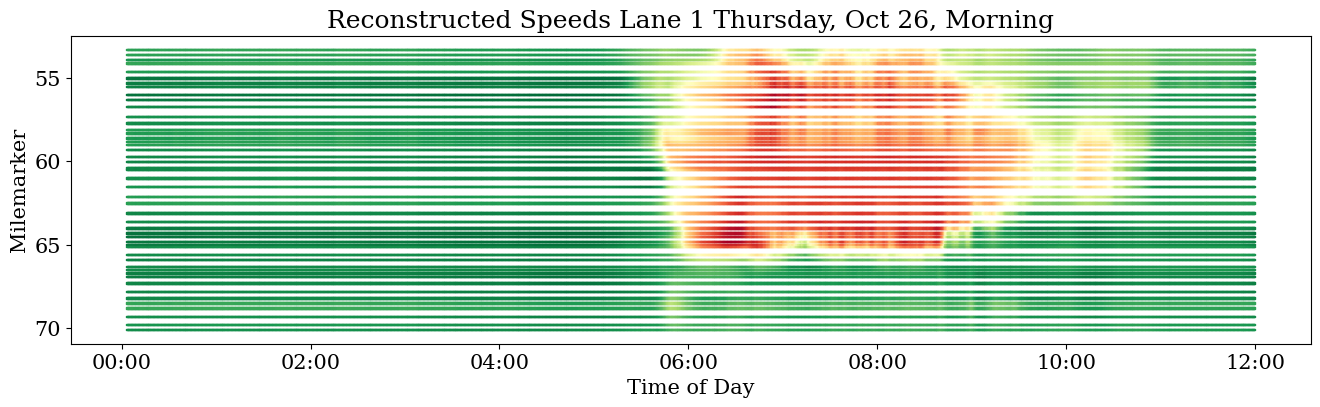

In [69]:
data['Time Index'] = pd.to_datetime(data['Time Index'] * 30, unit='s')
plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Reconstructed Speed'].values,marker='s',s=1, cmap='RdYlGn')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title("Reconstructed Speeds Lane 1 Thursday, Oct 26, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()

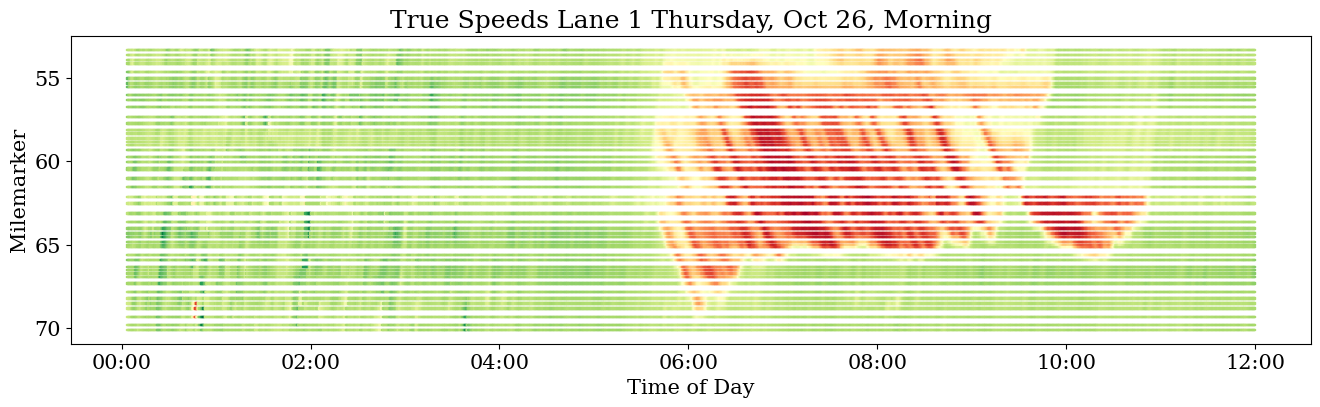

In [70]:
plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Speed'].values,marker='s',s=1, cmap='RdYlGn')
plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_locator(MultipleLocator(0.01))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Set x-axis limits
start_time = pd.to_datetime('1970-01-01 09:30:00')
end_time = pd.to_datetime('1970-01-01 09:50:00')
# plt.xlim(start_time, end_time)
# plt.ylim()

plt.title("True Speeds Lane 1 Thursday, Oct 26, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()

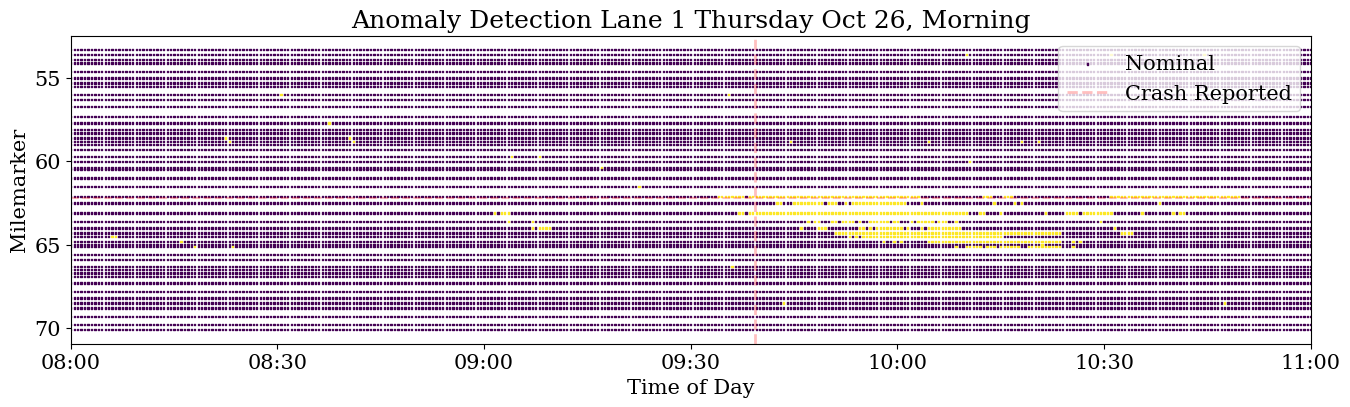

In [71]:
plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Anomaly'].values,marker='s',s=1, cmap='viridis', label='Nominal')
plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# Set x-axis limits
start_time = pd.to_datetime('1970-01-01 08:00:00')
end_time = pd.to_datetime('1970-01-01 11:00:00')
plt.xlim(start_time, end_time)

# Add vertical line at '1970-01-01 09:39:22'
vline_time = pd.to_datetime('1970-01-01 09:39:22')
plt.axvline(x=vline_time, color='red', linestyle='--', linewidth=2, label='Crash Reported', alpha=0.25)
plt.axhline(y=62.2, color='red', linestyle='--', alpha=0.25)
# plt.ylim(60,65)
plt.legend(loc='upper right')
plt.title("Anomaly Detection Lane 1 Thursday Oct 26, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()

# Friday, Dec 8 Morning

In [50]:
dec8_data = get_dec8_data(timesteps=best_params['timesteps'])

In [51]:
dec8_errors, dec8_recons_speeds, dec8_true_speeds = test_model(dec8_data, mse_weights, ae)

In [72]:
offset = 0
dec8_anomalies = threshold_anomalies(thresh + offset, dec8_errors)

In [73]:
df = fill_result_df(dec8_anomalies, dec8_true_speeds, dec8_recons_speeds, best_params['timesteps'])
df.to_csv('./saved_results/dec8_results_optw1.csv')

In [74]:
data = pd.read_csv('./saved_results/dec8_results_optw1.csv', index_col=0)

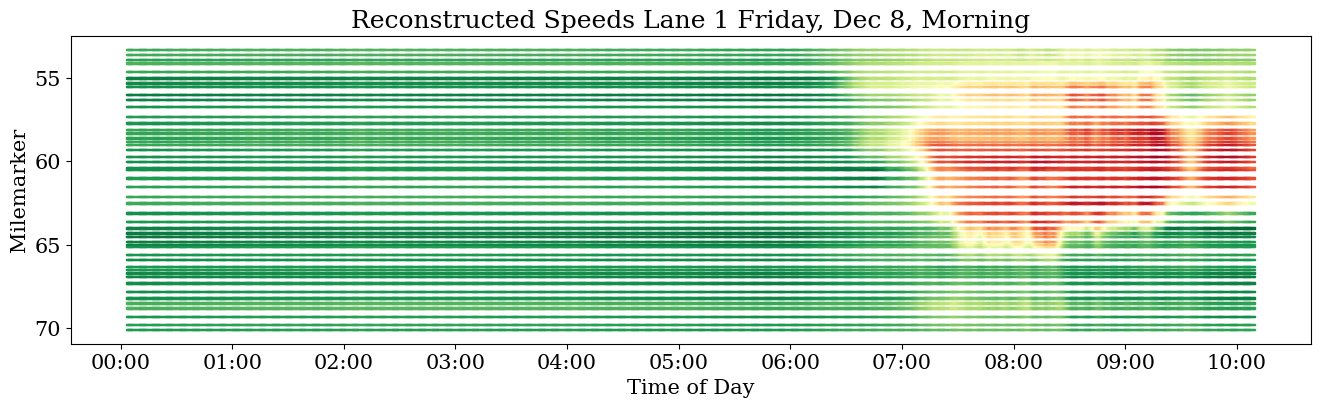

In [75]:
lane_no=1
data['Time Index'] = pd.to_datetime(data['Time Index'] * 30, unit='s')
plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == lane_no]
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Reconstructed Speed'].values,marker='s',s=1, cmap='RdYlGn')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title(f"Reconstructed Speeds Lane {lane_no} Friday, Dec 8, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()

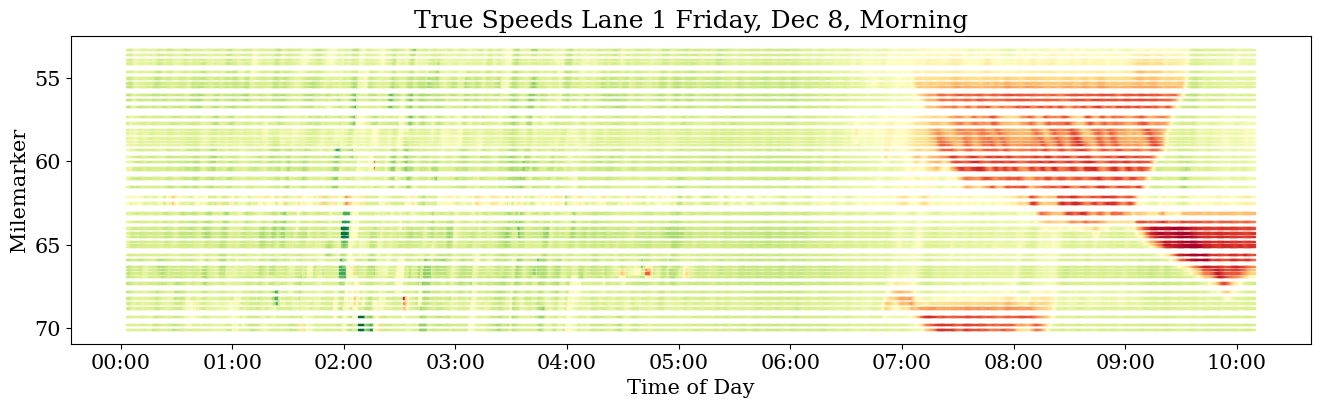

In [76]:
plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == lane_no]
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Speed'].values,marker='s',s=1, cmap='RdYlGn')
plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_locator(MultipleLocator(0.01))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Set x-axis limits
start_time = pd.to_datetime('1970-01-01 09:30:00')
end_time = pd.to_datetime('1970-01-01 09:50:00')
# plt.xlim(start_time, end_time)
# plt.ylim()

plt.title(f"True Speeds Lane {lane_no} Friday, Dec 8, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()

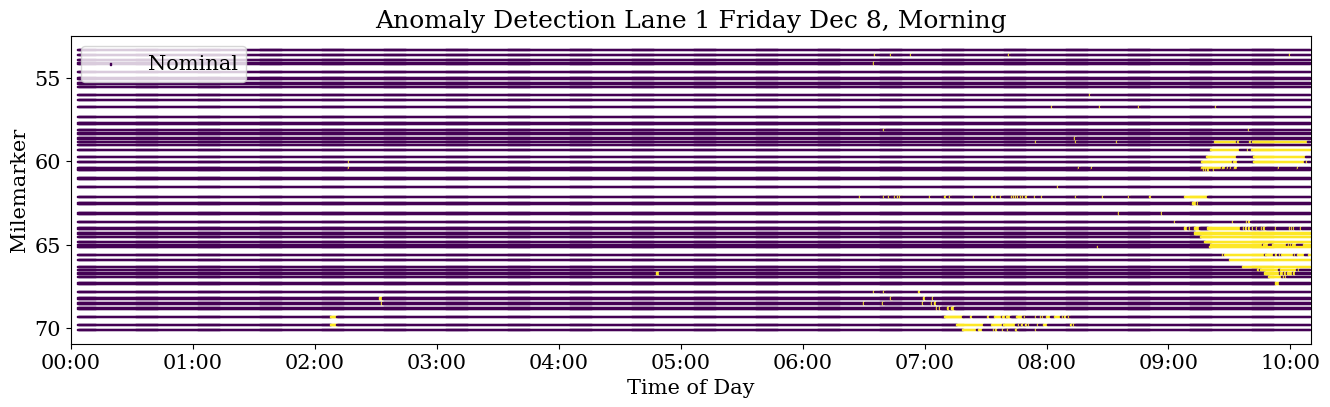

In [77]:
plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == lane_no]
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Anomaly'].values,marker='s',s=1, cmap='viridis', label='Nominal')
plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# Set x-axis limits
start_time = pd.to_datetime('1970-01-01 00:00:00')
end_time = pd.to_datetime('1970-01-01 10:10:00')
plt.xlim(start_time, end_time)

# Add vertical line at '1970-01-01 09:39:22'
vline_time = pd.to_datetime('1970-01-01 09:39:22')
# plt.axvline(x=vline_time, color='red', linestyle='--', linewidth=2, label='Crash Reported', alpha=0.25)
# plt.axhline(y=62.2, color='red', linestyle='--', alpha=0.25)
# plt.ylim(60,65)
plt.legend(loc='upper left')
plt.title(f"Anomaly Detection Lane {lane_no} Friday Dec 8, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()